In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
import pandas as pd
import gc

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate
from gsnn.optim.EarlyStopper import EarlyStopper
from gsnn.simulate.datasets import simulate_3_in_3_out

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


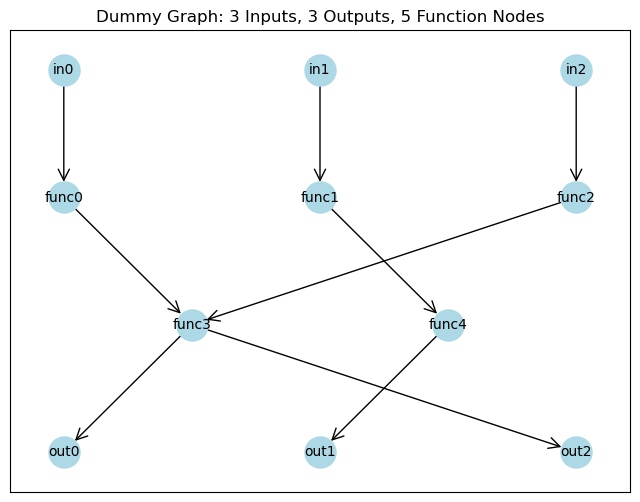

In [2]:
G, pos, x_train, x_test, y_train, y_test, input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=10, n_test=100, noise_scale=0.1, device='cuda')

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

# Performance comparison on simulated data

In [3]:
def train(model, model_params, train_params, x_train, y_train, x_test, y_test, device, max_epochs=500, patience=10): 

    gc.collect() 
    torch.cuda.empty_cache()

    model = model(**model_params).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    crit = torch.nn.MSELoss()

    early_stopper = EarlyStopper(patience=patience, min_delta=1e-3)

    losses = []
    for i in range(max_epochs): 
        model.train()
        optim.zero_grad() 
        yhat = model(x_train)
        loss = crit(y_train, yhat)
        loss.backward() 
        optim.step()

        with torch.no_grad(): 
            model.eval()
            loss = crit(model(x_test), y_test)
            losses.append(loss.item())
            if early_stopper.early_stop(loss): break

    del model; del optim; del crit 

    return losses

def run_search(model, model_params, training_params, x_train, y_train, x_test, y_test, device, iters=10):

    res = {**{k:[] for k in model_params.keys() if k not in ['edge_index_dict', 'node_names_dict']}, **{k:[] for k in training_params.keys()}}
    losses = []
    for i in range(iters): 
        print(f'progress: {i}/{iters}', end='\r')
        
        mp = {k:np.random.choice(model_params[k], size=1).item() for k,v in model_params.items()}
        tp = {k:np.random.choice(training_params[k], size=1).item() for k,v in training_params.items()}
        losses.append( train(model, mp, tp, x_train, y_train, x_test, y_test, device) )

        _=[res[k].append(v) for k,v in mp.items() if k not in ['edge_index_dict', 'node_names_dict']] 
        _=[res[k].append(v) for k,v in tp.items()]

    res = pd.DataFrame(res)
    return res, losses

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
iters = 250

gsnn_search_space = {'channels':np.arange(2, 40).tolist(), 
                'layers':[2,3,4],
                'share_layers':[True, False], 
                'add_function_self_edges':[True, False],
                'norm':['none', 'layer', 'batch', 'softmax'],
                'norm_first':[True, False],
                'init':['xavier', 'kaiming', 'lecun', 'normal'],
                'bias':[True, False], 
                'dropout':[0, 0.1],
                'residual':[True, False]}

gsnn_training_params = {'lr': [5e-1, 1e-2, 5e-3], 
                        'max_epochs':[100], 
                        'device':[device], 
                        'weight_decay':[0, 1e-2, 1e-4, 1e-6]} 

In [6]:
# GSNN with true graph structure
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

model_params = {**{'edge_index_dict':[data.edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn, test_losses_gsnn = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn = res_gsnn.assign(last_loss=[x[-1] for x in test_losses_gsnn], 
                            best_loss=[min(x) for x in test_losses_gsnn]) 


/home/teddy/local/GSNN/gsnn/models/GSNN.py:405: UserWarning: It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)
  if norm_first: warnings.warn('It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)')


In [7]:
# choose random edges from GSNN graph structure

edge_index_dict = copy.deepcopy(data.edge_index_dict)
E = edge_index_dict['function', 'to', 'function'].size(1)
edge_index_dict['function', 'to', 'function']  = torch.randint(low=0, high=len(function_nodes), size=(2,E))

model_params = {**{'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn_rand, test_losses_gsnn_rand = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn_rand = res_gsnn_rand.assign(last_loss=[x[-1] for x in test_losses_gsnn_rand], 
                            best_loss=[min(x) for x in test_losses_gsnn_rand]) 



/home/teddy/local/GSNN/gsnn/models/GSNN.py:405: UserWarning: It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)
  if norm_first: warnings.warn('It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)')


In [8]:
# Fully connected GSNN (all nodes connected to each other)

edge_index_dict = copy.deepcopy(data.edge_index_dict)
edge_index_dict['function', 'to', 'function']  = torch.stack((torch.arange(len(function_nodes)).repeat_interleave(len(function_nodes)), 
                                                              torch.arange(len(function_nodes)).repeat(len(function_nodes))), dim=0)

model_params = {**{'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn_full, test_losses_gsnn_full = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn_full = res_gsnn_full.assign(last_loss=[x[-1] for x in test_losses_gsnn_full], 
                            best_loss=[min(x) for x in test_losses_gsnn_full]) 


/home/teddy/local/GSNN/gsnn/models/GSNN.py:405: UserWarning: It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)
  if norm_first: warnings.warn('It is recommended to apply softmax normalization after the nonlinearity (set norm_first=False)')


In [26]:
nn_model_params = {'in_channels':[x_train.size(1)], 
                'out_channels':[y_train.size(1)], 
                'hidden_channels':[10,20,40,80,120], 
                'layers':[1,2,3],
                'norm':[torch.nn.BatchNorm1d, torch.nn.LayerNorm, None],
                'dropout':[0, 0.1, 0.25]}

nn_training_params = {'lr': [1e-2, 1e-3, 1e-4], 
                      'max_epochs':[100], 
                        'device':[device], 
                        'weight_decay':[0, 1e-2, 1e-4, 1e-6]} 

res_nn, losses_nn = run_search(NN, nn_model_params, nn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

In [27]:
print(f'best test loss NN: {min([min(loss) for loss in losses_nn])}')
print(f'best test loss GSNN: {min([min(loss) for loss in test_losses_gsnn])}')
print(f'best test loss GSNN (rand graph): {min([min(loss) for loss in test_losses_gsnn_rand])}')
print(f'best test loss GSNN (fully connected): {min([min(loss) for loss in test_losses_gsnn_full])}')

best test loss NN: 0.7409712672233582
best test loss GSNN: 0.43458792567253113
best test loss GSNN (rand graph): 0.9025983810424805
best test loss GSNN (fully connected): 0.5262340307235718


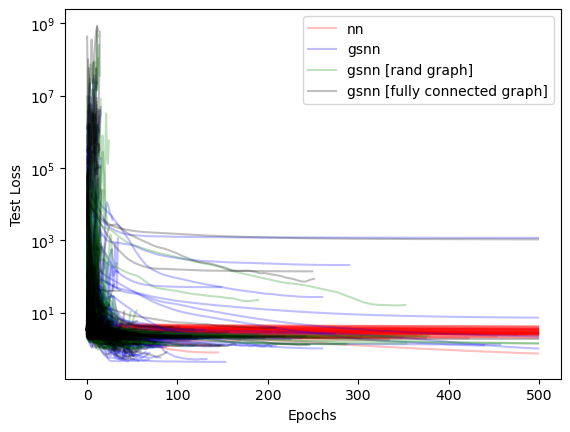

In [28]:
alpha = 0.25

plt.figure()

for i, loss in enumerate(losses_nn): 
    if i == 0: 
        plt.plot(loss, 'r-', label='nn', alpha=alpha)
    else:
        plt.plot(loss, 'r-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn):
    if i == 0: 
        plt.plot(loss, 'b-', label='gsnn', alpha=alpha)
    else:
        plt.plot(loss, 'b-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn_rand):
    if i == 0: 
        plt.plot(loss, 'g-', label='gsnn [rand graph]', alpha=alpha)
    else:
        plt.plot(loss, 'g-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn_full):
    if i == 0: 
        plt.plot(loss, 'k-', label='gsnn [fully connected graph]', alpha=alpha)
    else:
        plt.plot(loss, 'k-', alpha=alpha)

plt.xlabel('Epochs')
plt.ylabel('Test Loss')

#plt.ylim(0.,1.5)
plt.legend()
plt.yscale('log')
plt.show()

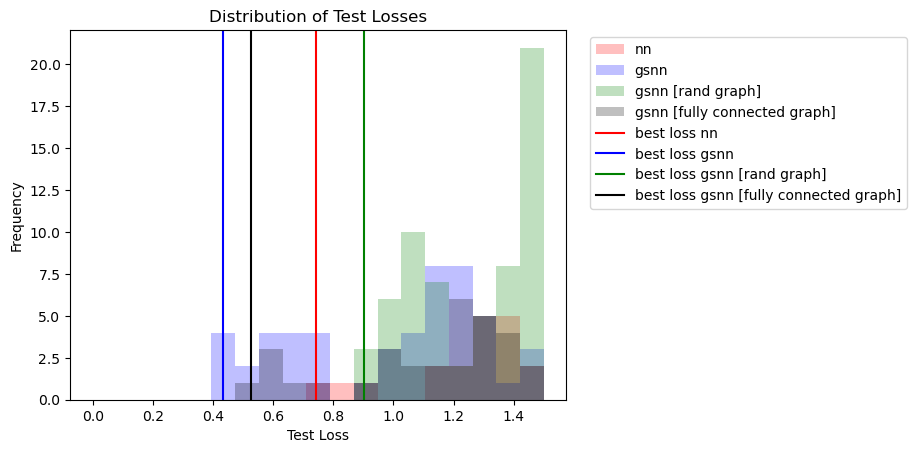

In [37]:
bins = np.linspace(0.,1.5,20)

plt.figure()
plt.hist([min(loss) for loss in losses_nn], label='nn', alpha=0.25, color='r', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn], label='gsnn', alpha=0.25, color='b', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn_rand], label='gsnn [rand graph]', alpha=0.25, color='g', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn_full], label='gsnn [fully connected graph]', alpha=0.25, color='k', bins=bins)

plt.axvline(np.nanmin([min(loss) for loss in losses_nn]),  color='r', label='best loss nn')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn]),  color='b', label='best loss gsnn')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn_rand]),  color='g', label='best loss gsnn [rand graph]')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn_full]), color='k', label='best loss gsnn [fully connected graph]')

plt.xlabel('Test Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Test Losses')

# place legend outside 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

plt.show()

In [30]:
# best gsnn hyper params 
res_gsnn.sort_values(by='best_loss', ascending=True).head(10)

,channels,layers,share_layers,add_function_self_edges,norm,norm_first,init,bias,dropout,residual,lr,max_epochs,device,weight_decay,last_loss,best_loss
33,25,3,True,True,none,True,kaiming,True,0.0,True,0.010,100,cuda,0.010000,0.434588,0.434588
206,36,4,False,True,batch,True,lecun,True,0.1,True,0.005,100,cuda,0.000001,0.471251,0.450774
23,38,4,False,False,batch,False,kaiming,True,0.0,True,0.005,100,cuda,0.000000,0.469088,0.454098
164,14,4,False,True,batch,True,lecun,True,0.1,True,0.010,100,cuda,0.000100,0.501884,0.464921
53,8,2,True,False,batch,True,xavier,True,0.0,False,0.005,100,cuda,0.010000,0.523996,0.506210
24,29,4,False,False,batch,False,lecun,True,0.0,True,0.010,100,cuda,0.000001,0.577366,0.525904
49,17,2,False,False,none,False,lecun,True,0.0,False,0.005,100,cuda,0.000100,0.774596,0.565746
207,25,3,False,False,batch,True,lecun,True,0.0,True,0.010,100,cuda,0.010000,0.572210,0.567541
145,29,4,False,True,batch,False,kaiming,False,0.1,True,0.500,100,cuda,0.000001,0.997125,0.571470
220,12,2,True,False,batch,False,xavier,True,0.1,False,0.500,100,cuda,0.000001,0.817164,0.583296


In [31]:
res_gsnn.sort_values(by='best_loss', ascending=False).head(10)

,channels,layers,share_layers,add_function_self_edges,norm,norm_first,init,bias,dropout,residual,lr,max_epochs,device,weight_decay,last_loss,best_loss
91,33,4,False,True,none,False,xavier,True,0.1,False,0.500,100,cuda,0.000000,1.941624e+07,187018.937500
103,30,3,False,True,none,True,lecun,True,0.1,False,0.500,100,cuda,0.000001,2.693401e+06,7308.814941
80,21,4,False,True,none,True,lecun,False,0.1,False,0.500,100,cuda,0.000001,3.025136e+06,1333.602173
87,30,4,False,True,none,True,normal,True,0.0,True,0.010,100,cuda,0.000100,1.173812e+03,1173.811890
128,36,4,True,True,batch,True,xavier,False,0.0,False,0.500,100,cuda,0.000001,5.781302e+02,542.044006
144,12,3,False,True,none,True,normal,True,0.1,True,0.500,100,cuda,0.010000,1.833441e+05,390.702087
67,26,4,True,True,none,True,normal,False,0.1,False,0.005,100,cuda,0.000100,2.082199e+02,208.058334
173,13,4,True,True,none,False,kaiming,True,0.1,True,0.500,100,cuda,0.000000,1.388970e+03,149.772797
191,32,2,False,True,none,True,normal,True,0.0,False,0.005,100,cuda,0.010000,5.087666e+01,50.802998
20,14,4,False,True,none,False,xavier,False,0.1,True,0.500,100,cuda,0.000001,2.480873e+03,48.849541


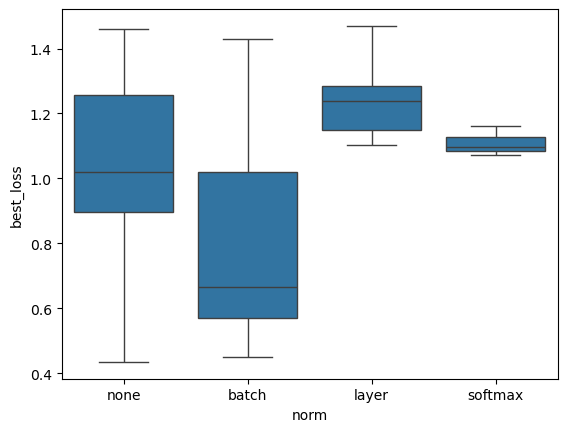

In [32]:
plt.figure()
sbn.boxplot(x='norm', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

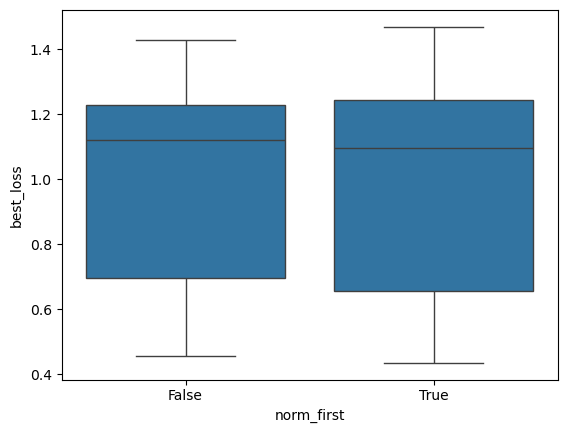

In [33]:
plt.figure()
sbn.boxplot(x='norm_first', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

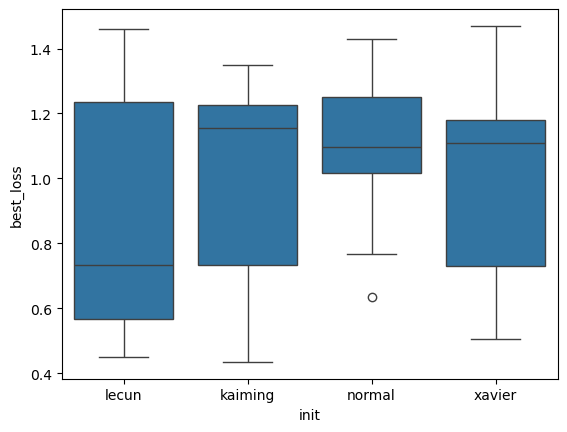

In [16]:
plt.figure() 
sbn.boxplot(x='init', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

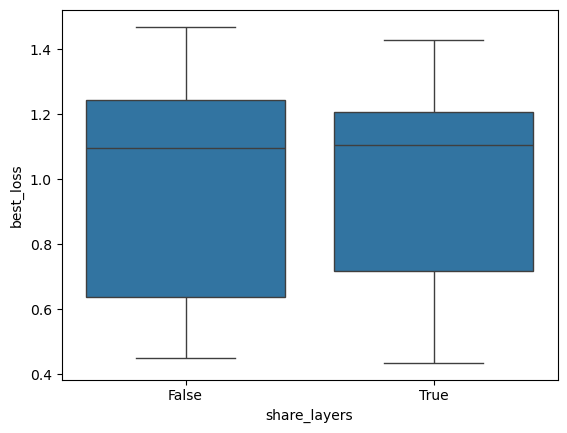

In [17]:
plt.figure() 
sbn.boxplot(x='share_layers', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

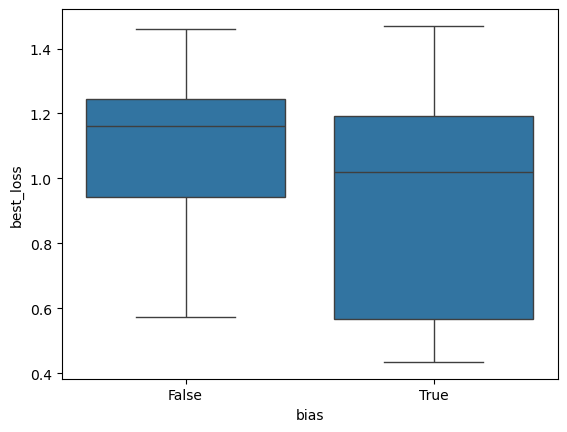

In [18]:
plt.figure() 
sbn.boxplot(x='bias', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

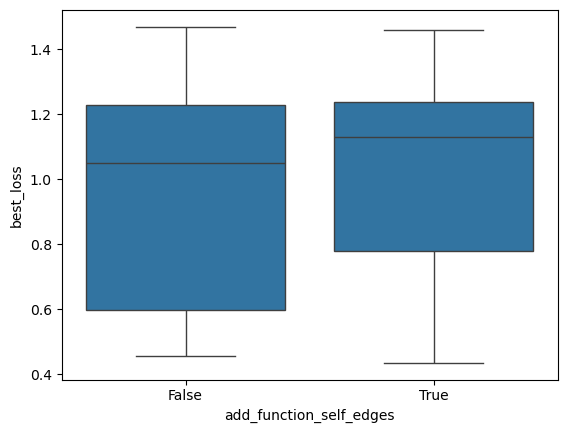

In [19]:
plt.figure() 
sbn.boxplot(x='add_function_self_edges', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

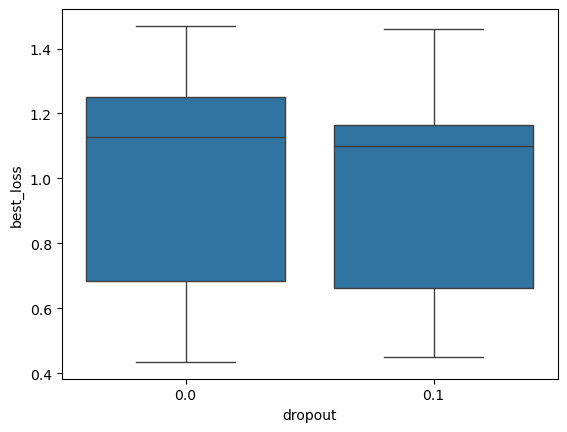

In [20]:
plt.figure() 
sbn.boxplot(x='dropout', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

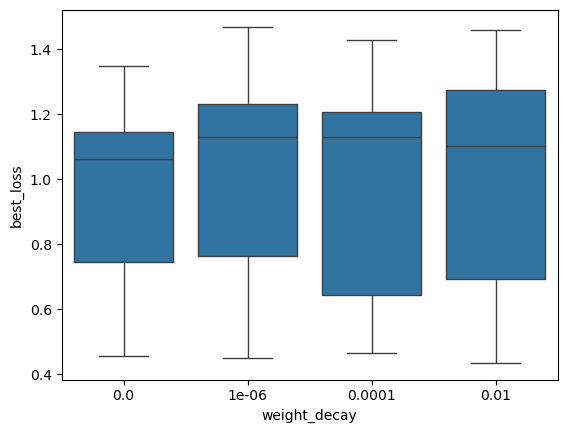

In [21]:
plt.figure() 
sbn.boxplot(x='weight_decay', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

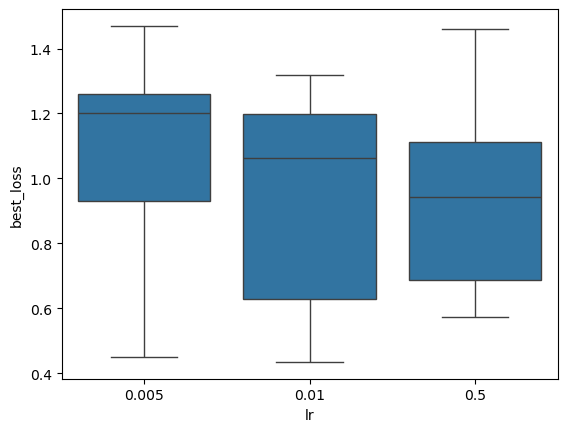

In [22]:
plt.figure() 
sbn.boxplot(x='lr', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

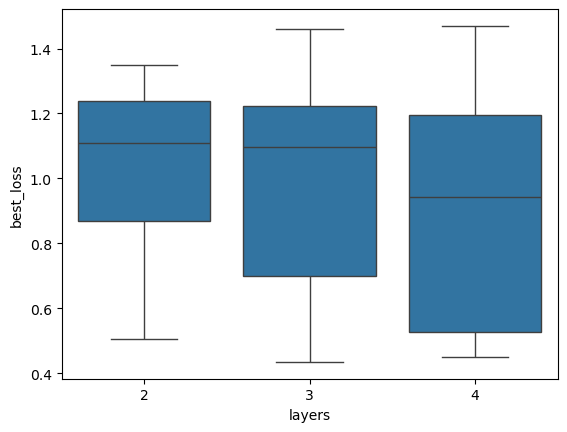

In [23]:
plt.figure() 
sbn.boxplot(x='layers', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

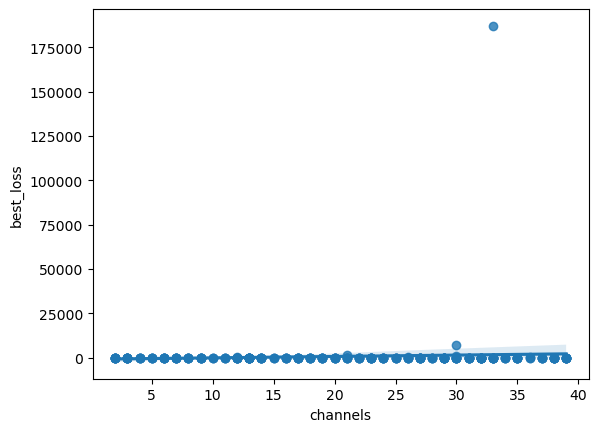

In [24]:
plt.figure() 
sbn.regplot(x='channels', y='best_loss', data=res_gsnn)
plt.show() 

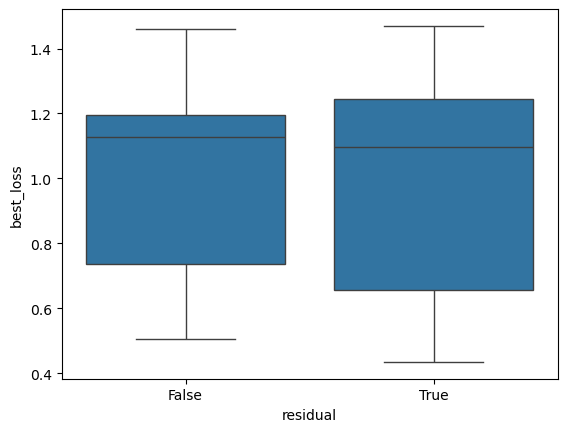

In [25]:
plt.figure() 
sbn.boxplot(x='residual', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 